### Classical Base Model: MNIST Data

Here, we experiment with a model with basic CNN layers and classical contrastive pair loss to make the model predict whether 2 images belong to the same class or different class.

We will make pairs of images, if they belong to the same class the label will be set to 1, otherwise 0. The model's goal will be to predict the label correctly.

We will consider only images of 0 and 1 from MNIST dataset, as the datasets we will use later on are also binary (electron-photon or quark-gluon)

In [1]:
# Required Imports
import wandb

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, initializers

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import confusion_matrix as cmatrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

### Data Loading and Pre-processing

In [2]:
# loading the data as train and test
data = np.load('../data/electron-photon-large.npz', allow_pickle=True)

x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(398400, 32, 32, 2) (99600, 32, 32, 2)
(398400,) (99600,)


In [3]:
x_train = x_train[:,:,:,0]
x_test = x_test[:,:,:,0]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(398400, 32, 32) (99600, 32, 32)
(398400,) (99600,)


In [4]:
assert not np.isnan(x_train).any(), "Images contain NaN values!"
assert not np.isinf(y_train).any(), "Images contain infinite values!"
assert not np.isnan(x_test).any(), "Labels contain NaN values!"
assert not np.isinf(y_test).any(), "Labels contain infinite values!"

In [5]:
# assert not np.isnan(pairs_train[:,0]).any(), "Images contain NaN values!"
# assert not np.isnan(pairs_train[:,1]).any(), "Images contain NaN values!"
# assert not np.isinf(labels_train).any(), "Images contain infinite values!"
# # assert not np.isnan(x_test).any(), "Labels contain NaN values!"
# # assert not np.isinf(y_test).any(), "Labels contain infinite values!"

NameError: name 'pairs_train' is not defined

In [6]:
# Preprocess the dataset
def preprocess_data(images, labels):
    images = np.expand_dims(images, -1)
    images = images.astype('float32') / 255.0  # Normalize
    return images, labels

In [7]:
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(398400, 32, 32, 1) (99600, 32, 32, 1)
(398400,) (99600,)


In [8]:
def crop(images, size):
    x = np.argmax(np.mean(images[:, :, :, 0], axis=0))
    center = [int(x/size), x%size]
    img_size = 8
    images = images[:, (center[0]-int(img_size/2)):(center[0]+int(img_size/2)), (center[1]-int(img_size/2)):(center[1]+int(img_size/2))]
    return images

In [9]:
x_train = crop(x_train, 32)
x_test = crop(x_test, 32)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(398400, 8, 8, 1) (99600, 8, 8, 1)
(398400,) (99600,)


### Defining the Model

In [10]:
# Create pairs of images and labels
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = len(np.unique(labels)) # 2
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    print(digit_indices)

    for idx1 in range(len(images)):
        x1, label1 = images[idx1], labels[idx1]
        idx2 = np.random.choice(digit_indices[int(label1)])
        x2 = images[idx2]

        # if x1==x2, label set to 1
        pairs.append([x1, x2])
        pair_labels.append(1)

        # if x1!=x2, label set to 0
        label2 = (label1 + np.random.randint(1, num_classes)) % num_classes
        idx2 = np.random.choice(digit_indices[int(label2)])
        x2 = images[idx2]
        pairs.append([x1, x2])
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

In [11]:
pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)

print(pairs_train.shape, pairs_test.shape)
print(labels_train.shape,labels_test.shape)

[array([     0,      2,      3, ..., 398394, 398395, 398396], dtype=int64), array([     1,      4,      5, ..., 398397, 398398, 398399], dtype=int64)]
[array([    0,     2,     4, ..., 99595, 99596, 99599], dtype=int64), array([    1,     3,     5, ..., 99594, 99597, 99598], dtype=int64)]
(796800, 2, 8, 8, 1) (199200, 2, 8, 8, 1)
(796800,) (199200,)


In [12]:
def plot_sample_pairs(pairs, labels, shape, num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(pairs[i, 0].reshape(shape, shape), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(pairs[i, 1].reshape(shape, shape), cmap='gray')
        ax.axis('off')

        label = labels[i]
        plt.title(f'Sample: {i}, Label: {label}')

    plt.tight_layout()
    plt.show()

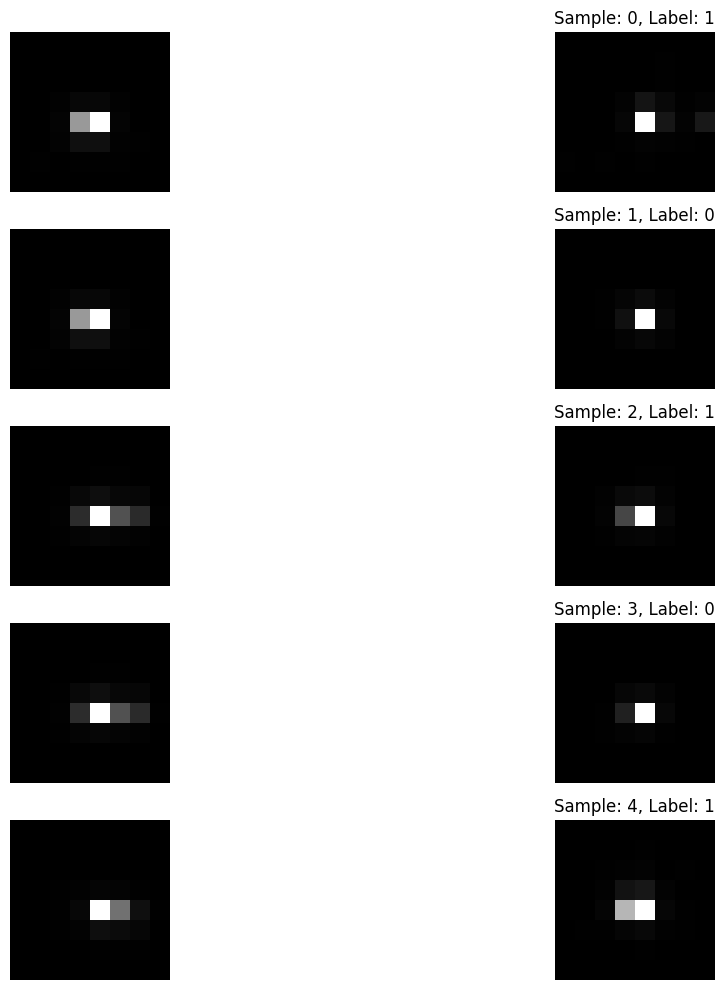

In [13]:
plot_sample_pairs(pairs_train, labels_train, shape=8)

In [21]:
# Contrastive loss function based on margin
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

In [25]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="ML4Sci-QuantumContrastiveLearning",

    # track hyperparameters and run metadata with wandb.config
    config={
        "input_shape": pairs_train.shape[2:],
        "layer_1": 4,
        "kernel": (2,2),
        "strides": (1,1),
        "activation_1": "relu",
        "layer_2": 8,
        "activation_2": "leaky_relu",
        "optimizer": "adam",
        "loss": "contrastive_pair_loss",
        "dropout": 0.5,
        "epoch": 20,
        "batch_size": 32,
        "architecture": "Base CNN",
        "dataset": "electron-photon"
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [26]:
config = wandb.config

In [28]:
# Define the CNN model 
# def create_base_model(input_shape):
#     model = models.Sequential()
#     model.add(layers.Input(shape=input_shape))
#     model.add(layers.Conv2D(4, (2, 2), strides=(1,1), activation='relu',kernel_initializer=initializers.HeNormal())) # Conv layer 1
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(8, (2, 2), strides=(1,1), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))) # Conv layer 2
#     model.add(layers.Dropout((0.5)))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(8, activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     # model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
#     return model
    
# Define the CNN model 
def create_base_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(config.layer_1, config.kernel, strides=config.strides, activation=config.activation_1,kernel_initializer=initializers.HeNormal())) 
    model.add(layers.MaxPooling2D(config.kernel))
    model.add(layers.Conv2D(config.layer_2, config.kernel, strides=config.strides, activation=config.activation_1,kernel_regularizer=tf.keras.regularizers.l2(0.01))) 
    model.add(layers.Dropout((config.dropout)))
    model.add(layers.Flatten())
    model.add(layers.Dense(config.layer_2, activation=config.activation_2,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    return model

In [29]:
# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_base_model(input_shape)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])
    
    model = models.Model([input_0, input_1], distance)
    
    return model

In [30]:
# Define the model
import os
checkpoint_path = "cnn_base_1_ep/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

input_shape = pairs_train.shape[2:]
siamese_network = create_siamese_network(input_shape)

siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam(learning_rate=1e-3,clipnorm=1.0))

# history = siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
#     validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
#     epochs=10,
#     batch_size=32,
#     callbacks=[cp_callback]
# )

history = siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=config.epoch,
    batch_size=config.batch_size,
    callbacks=[cp_callback]
)

Epoch 1/20
24898/24900 [============================>.] - ETA: 0s - loss: 0.2667
Epoch 1: saving model to cnn_base_1_ep\cp.ckpt
24900/24900 [==============================] - 243s 10ms/step - loss: 0.2667 - val_loss: 0.5020
Epoch 2/20
13434/24900 [===============>..............] - ETA: 2:09 - loss: nan

KeyboardInterrupt: 

In [31]:
wandb.finish()

In [24]:
siamese_network.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 1)                    417       ['input_8[0][0]',             
                                                                     'input_9[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None,)                      0         ['sequential_2[0][0]',  

<Axes: title={'center': 'Learning History'}>

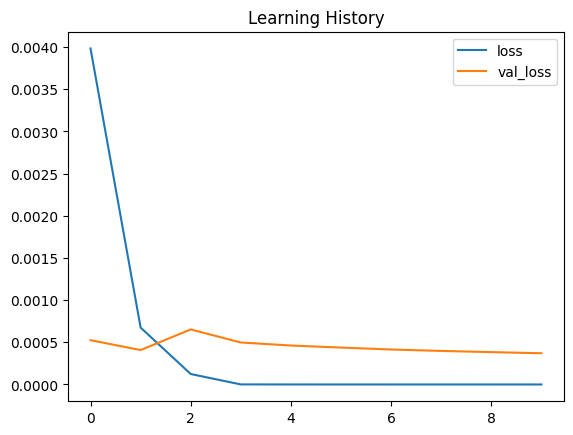

In [20]:
pd.DataFrame(history.history).plot(title="Learning History")

### Evaluation of the model

In [57]:
# Predictions from the model
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])

5864/6225 [===========================>..] - ETA: 0s

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000021E7D751480>>
Traceback (most recent call last):
  File "C:\Users\Sanya Nanda\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


6225/6225 [==============================] - 59s 9ms/step


In [24]:
distance

array([2.8014183e-06, 9.9999332e-01, 7.1885915e-09, ..., 9.9999750e-01,
       0.0000000e+00, 9.9999899e-01], dtype=float32)

In [41]:
def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

In [42]:
y_pred = distances_to_labels(distance)

In [27]:
def plot_samples_with_predictions(test_pairs, test_labels, predictions, distances, num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(test_pairs[i, 0].reshape(28, 28), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(test_pairs[i, 1].reshape(28, 28), cmap='gray')
        ax.axis('off')

        label = test_labels[i]
        pred = predictions[i]
        dist = distances[i]
        plt.title(f'True: {label}, Pred: {pred}, Dist: {dist:0.15f}')

    plt.tight_layout()
    plt.show()

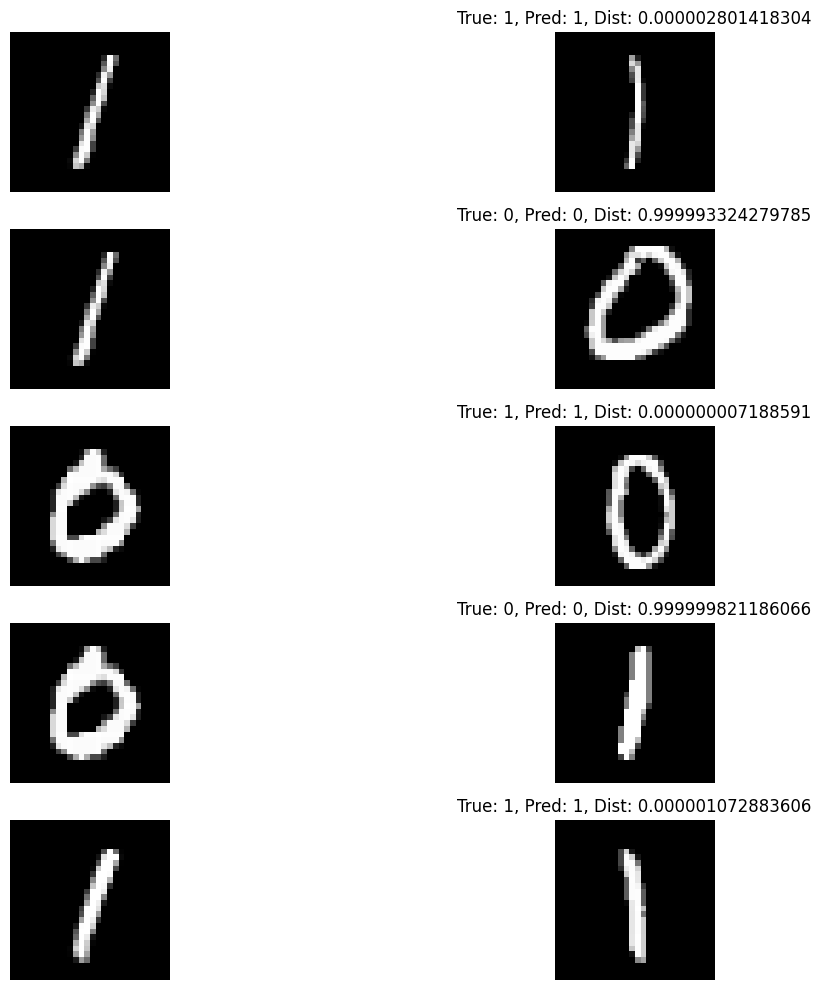

In [28]:
# Plot sample pairs with predictions
plot_samples_with_predictions(pairs_test, labels_test, y_pred, distance, num_samples=5)

In [29]:
def evaluate_precision_recall_accuracy(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))
    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))
    
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    accuracy = (true_positives + true_negatives) / len(y_true)
    
    return precision, recall, accuracy

In [30]:
evaluate_precision_recall_accuracy(labels_test,y_pred)

(0.9990543735224586, 0.9990543735224586, 0.9990543735224586)

In [31]:
def confusion_matrix(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))
    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))
    
    return np.array([[true_negatives, false_positives],
                     [false_negatives, true_positives]])

In [32]:
confusion_matrix(labels_test,y_pred)

array([[2113,    2],
       [   2, 2113]])

In [47]:
def make_cm(y_true,y_pred,classes=None,figsize=(10,10),text_size=15):
  cm = cmatrix(y_true,tf.round(y_pred))
  cm_norm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis] # normalise confusion matrix
  n_class = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm,cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels=classes
  else:
    labels=np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix", 
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_class),
        yticks=np.arange(n_class),
        xticklabels=labels,
        yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)


  threshold = (cm.max()+cm.min())/2

  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f})%",
            horizontalalignment="center",
            color="white" if cm[i,j]>threshold else "black",
            size=text_size)

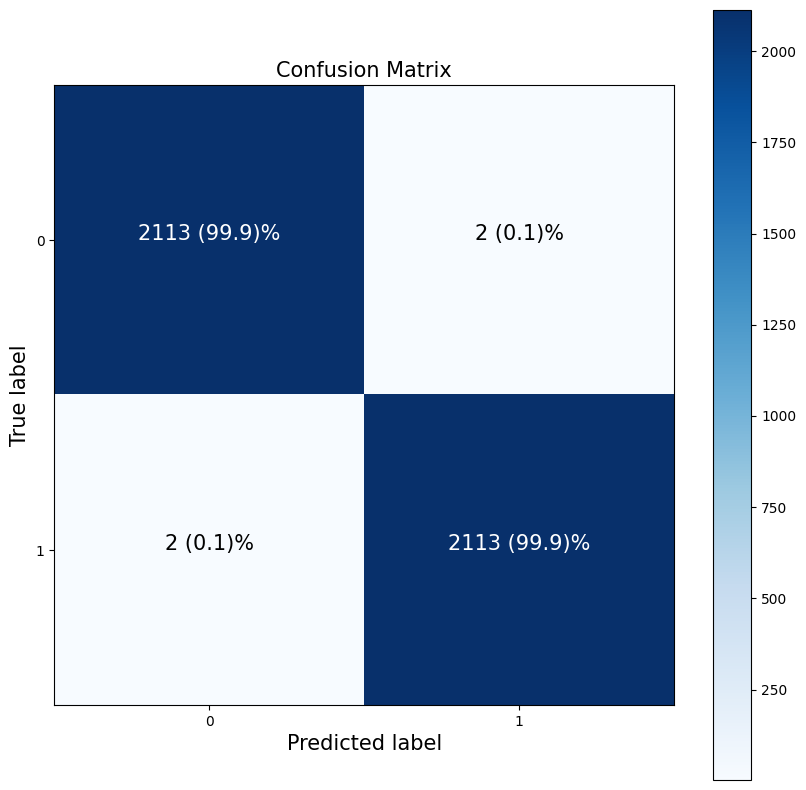

In [48]:
make_cm(labels_test,y_pred,["0","1"])

We see that precision, recall and accuracy; all have very high values indicating that the model worked well on MNIST data.

This is further put to a visual understanding using the confusion matrix above, which clearly shows that the model predicts the correct label on test pairs most of the time.

And the ROC curve below, suggests the same with area being 1.

In [49]:
def plot_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


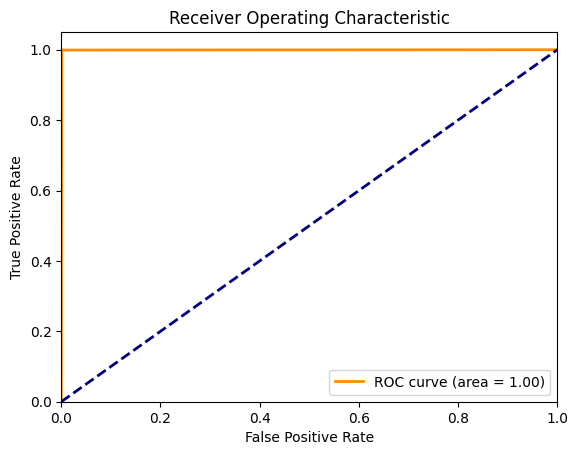

In [50]:
plot_auc(labels_test,y_pred)

### Saving and Loading the model

In [22]:
# save the model
saved_model_path = '../saved_models/classical_base_model_1.keras'
siamese_network.save(saved_model_path)
# Load the model
custom_objects={"contrastive_loss": contrastive_loss}
loaded_model = tf.keras.models.load_model(saved_model_path, safe_mode=False, custom_objects=custom_objects)
# Verify
loaded_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 1)                 │         514,561 │ input_layer_1[0][0],       │
│                               │                           │                 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 1)                 │               0 │ sequential[0][0],          │
│                               │                           │                 │ sequential[1][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,543,685 (5.89 MB)

 Trainable params: 514,561 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,029,124 (3.93 MB)